The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Achieved error threshold at step 70


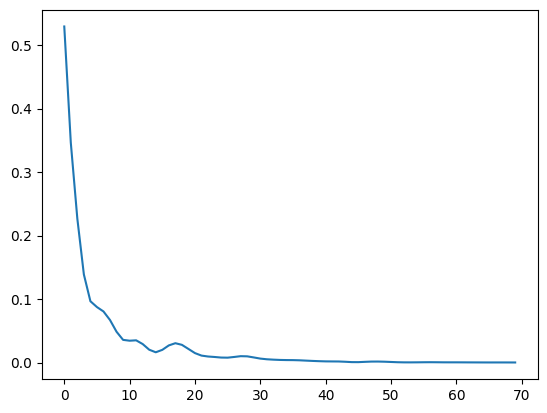

In [8]:
import pennylane as qml
import pennylane.numpy as nps
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from compressor.compilation import compilation
%load_ext autoreload
%autoreload 2
num_qubits = 3
num_layers = 3

thetas = nps.random.rand(3*num_layers*num_qubits) # Must nps array
state = np.random.rand(2**num_qubits)
state = state/np.linalg.norm(state)
costs, thetass = compilation(state, thetas, num_layers)
plt.plot(costs)

In [11]:
import qiskit.quantum_info


qc = qiskit.QuantumCircuit(num_qubits)
qc.prepare_state(state)
qcx = qiskit.transpile(qc, basis_gates=['h','s','cx','u','rx','ry','rz']).inverse()
print(qiskit.quantum_info.Statevector.from_instruction(qcx))
print(state)

Statevector([ 8.20039290e-02-1.42180577e-17j,
              1.43741658e-17+8.55544791e-03j,
             -4.83673495e-16-6.21456419e-01j,
              6.48363815e-02-1.48152823e-16j,
             -1.01020121e-01+1.75151354e-17j,
             -1.77074440e-17-1.05394022e-02j,
              5.95834320e-16+7.65568232e-01j,
             -7.98715283e-02+1.82508526e-16j],
            dims=(2, 2, 2))
[0.08200393 0.00855545 0.33134805 0.52973607 0.3525624  0.61865915
 0.30876594 0.02035999]


In [25]:
dev = qml.device("default.qubit")
@qml.qnode(dev, diff_method="parameter-shift")
def circuit():
	qml.Hadamard(wires=0)
	qml.CNOT(wires=[0, 1])
	return qml.probs(wires=range(num_qubits))

print(circuit()[0])

0.4999999999999999


In [27]:
thetass[-1]

tensor([ 0.70020769,  0.08633087,  0.30494722, -0.282037  ,  0.42343972,
         1.22105516,  0.12005875,  0.13731829,  1.09668547,  0.41208796,
         0.57447336,  1.02062   ,  0.63634333, -0.34773784,  0.26291723,
         0.38110435, -0.10566498,  0.24782165,  0.34538273,  0.91146486,
         0.8196674 ,  0.92367704,  0.74576046,  0.94660448,  0.33086232,
         0.72536328,  0.11798345], requires_grad=True)

In [3]:
num_qubits = 3
num_layers = 3
dev = qml.device("default.qubit", wires = 3)
@qml.qnode(dev)
def circuit(thetas):
	k = 0
	for _ in range(num_layers):
		for i in range(0, num_qubits - 1):
			qml.CNOT(wires = [i, i+1])
		qml.CNOT(wires = [num_qubits - 1, 0])
		for i in range(0, num_qubits):
			qml.RX(thetas[k], wires = i)
			qml.RY(thetas[k+1], wires = i)
			qml.RZ(thetas[k+2], wires = i)
			k += 3
	return qml.state()
print(state)
print(circuit(thetass[-1]))


[0.42842827 0.36914719 0.49499007 0.12886094 0.34509788 0.10600971
 0.43210104 0.31861787]
[-0.24112869-0.35106043j -0.19358695-0.29074681j -0.27787279-0.41036362j
 -0.24268348-0.3560138j  -0.20482328-0.30732912j -0.05759358-0.08606986j
 -0.07491875-0.10504925j -0.18126665-0.26213862j]


<img src='./images/grad.png'>

In [6]:

from compressor.utils import state_to_qc
from compressor.compilation import circuit_curry
pl_qiskit_circuit = state_to_qc(state)
circuit = circuit_curry(pl_qiskit_circuit, num_qubits, num_layers)
print(circuit(thetass[-1]))
print(qml.draw(circuit)(thetass[-1]))

[9.99924994e-01 1.97499504e-06 1.66765833e-05 1.23174111e-05
 6.24234019e-06 4.35341166e-07 1.92116449e-05 1.81473543e-05]
0: ─╭●────╭X──RX(1.15)───RY(0.23)───RZ(0.56)──╭●────╭X──RX(1.04)───RY(0.21)───RZ(0.39)──╭●────╭X
1: ─╰X─╭●─│───RX(-0.45)──RY(-0.48)──RZ(-0.14)─╰X─╭●─│───RX(0.74)───RY(-0.15)──RZ(-0.09)─╰X─╭●─│─
2: ────╰X─╰●──RX(0.24)───RY(0.11)───RZ(0.10)─────╰X─╰●──RX(-0.34)──RY(0.24)───RZ(1.53)─────╰X─╰●

───RX(0.48)──RY(0.80)──RZ(0.83)──U3(-2.52,3.14,-0.00)─╭X──U3(-1.57,-1.63,1.57)─╭X
───RX(1.43)──RY(0.95)──RZ(0.29)───────────────────────╰●───────────────────────│─
───RX(0.56)──RY(0.37)──RZ(1.32)────────────────────────────────────────────────╰●

───U3(-1.57,1.57,-1.97)─╭X──U3(-1.55,1.57,-0.00)──────────────────────────┤ ╭Probs
────────────────────────╰●──U3(-0.14,0.00,-0.00)─╭X──U3(-1.33,1.57,6.28)──┤ ├Probs
─────────────────────────────────────────────────╰●──U3(-1.41,0.00,-0.00)─┤ ╰Probs


In [51]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit

# Số qubit
num_qubits = 2  

# Khởi tạo thiết bị Pennylane
dev = qml.device("default.qubit", wires=num_qubits)

# Tạo mạch Qiskit
qiskit_circuit = QuantumCircuit(num_qubits)
qiskit_circuit.h(0)  # Cổng Hadamard trên qubit 0
qiskit_circuit.cx(0, 1)  # CNOT giữa qubit 0 và 1

# Chuyển đổi sang Pennylane
pl_qiskit_circuit = qml.from_qiskit(qiskit_circuit)

# Định nghĩa mạch Pennylane
@qml.qnode(dev)
def circuit():
    # Thêm mạch Qiskit đã chuyển đổi
    
    
    # Thêm các cổng bổ sung của Pennylane nếu cần
    qml.RY(np.pi / 4, wires=0)
    pl_qiskit_circuit()
    return qml.probs(wires=range(num_qubits))

# Chạy mạch
print(qml.draw(circuit)())


0: ──RY(0.79)──H─╭●─┤ ╭Probs
1: ──────────────╰X─┤ ╰Probs


In [5]:
state2 = state.copy()
noise = np.random.normal(0, 0.001, state.shape[0])
state2 += noise
state2 = state2 / np.linalg.norm(state2)

In [12]:


thetas_x = thetass[-1]
thetas_y, cost_func_at_y = thetas_x_to_thetas_y(thetas_x, num_layers)
thetas_y, cost_func_at_y

(tensor([-0.164905  , -0.08639654,  1.42716601,  1.02765381, -0.01238351,
         -0.56009823, -0.05564085, -0.15736174,  0.13351433,  0.89111409,
          0.28462231,  0.41131601,  0.22572056,  0.72147614,  0.27312311,
          0.67217857,  0.57745907,  0.58431527], requires_grad=True),
 0.019828901183317815)

In [20]:
cost_at_thetas_x_y_of_y = cost_func_at_y(thetas_x_at_y)
cost_at_thetas_x_y_of_y

0.005351377911386068

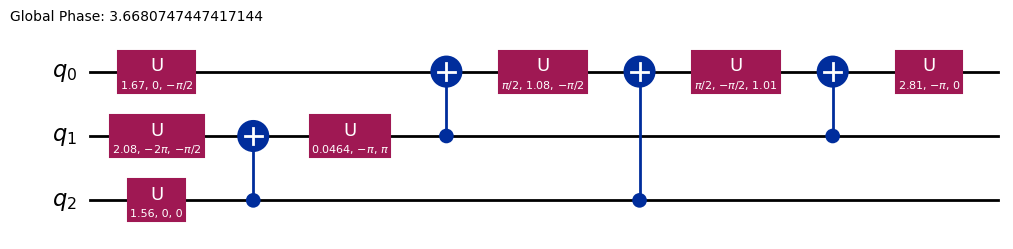

In [6]:
import qiskit
state1 = np.random.rand(2**num_qubits)
state1 = state1/np.linalg.norm(state1)
qc = qiskit.QuantumCircuit(num_qubits)
qc.prepare_state(state1)
qcx = qiskit.transpile(qc, basis_gates=['h','s','cx','u','rx','ry','rz'], optimization_level=3)
qcx.draw('mpl')

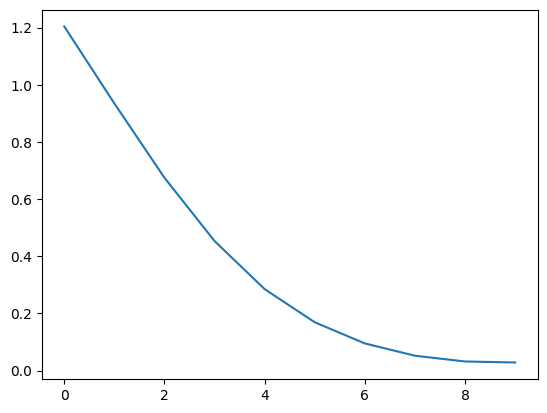

In [7]:
import matplotlib.pyplot as plt
plt.plot(costs)

In [8]:
from qoop.compilation.qcompilation import QuantumCompilation
from qoop.core import ansatz
import qiskit
import numpy as np

num_qubits = 3

arr = np.random.uniform(0, 2*np.pi, 2**num_qubits)
arrx = arr.copy()
noise = np.random.normal(0, 0.01, arrx.shape)
arrx += noise
arrx = arrx/np.linalg.norm(arrx)
arr = arr/np.linalg.norm(arr)


In [9]:
import matplotlib.pyplot as plt

In [10]:
compiler.thetass[-1]

NameError: name 'compiler' is not defined

In [ ]:

compiler1 = QuantumCompilation(
    u = ansatz.g2gn(num_qubits, 2),
    vdagger = arrx,
    thetas = compiler.thetass[-1]
)

compiler1.fit(num_steps=100)

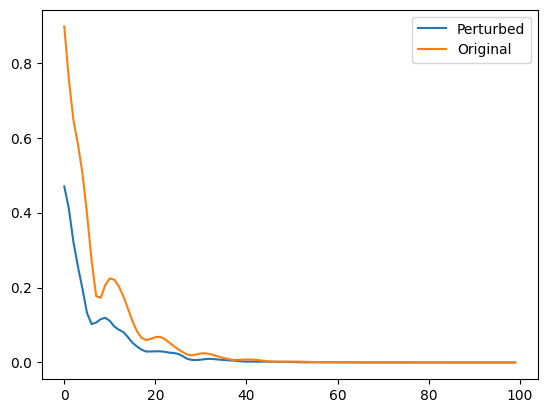

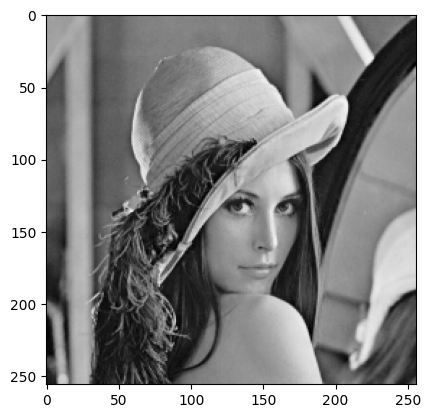

In [1]:
# read lenna and resize at 28 x 28 and save it
import cv2
from compressor.utils import divide_image
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('./images/lenna.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
plt.imshow(img, cmap='gray')
%load_ext autoreload
%autoreload 2

In [2]:

blocks, scales = divide_image(img, 2)
print(blocks[0] - blocks[1])

block_differences = [np.linalg.norm(blocks[i] - blocks[i+1]) / np.linalg.norm(blocks[i]) * 100 for i in range(len(blocks)-1)]


[ 0.00672255 -0.00522654  0.00374196 -0.00522654]


In [3]:
from qoop.compilation.qcompilation import QuantumCompilation
from qoop.core import ansatz, state
num_qubits=2
compiler = QuantumCompilation(
    u = ansatz.g2gn(num_qubits, 2),
    vdagger = blocks[0],
)
compiler.fit(num_steps=100)

Reset thetas to 1


In [8]:
compiler.thetass

[array([0.90000001, 0.9       , 1.1       , 1.1       , 0.9       ,
        0.9       , 1.09999999, 1.09999999, 0.90000001, 0.90000001,
        0.9       , 0.9       ]),
 array([0.8043658 , 0.80429006, 1.19728818, 1.1972657 , 0.80268491,
        0.80269125, 1.19767115, 1.19767005, 0.80928039, 0.80999797,
        0.80423714, 0.8042539 ]),
 array([0.72091549, 0.72053401, 1.28851399, 1.28841526, 0.71259637,
        0.71262844, 1.29063752, 1.29061013, 0.74006534, 0.74319772,
        0.72007323, 0.72015484]),
 array([0.65862016, 0.65787341, 1.36787535, 1.36773186, 0.638123  ,
        0.63817957, 1.37420636, 1.37407999, 0.69239356, 0.69800545,
        0.65628224, 0.65647885]),
 array([0.61859107, 0.61780343, 1.42787553, 1.42787526, 0.58745281,
        0.58748044, 1.44018031, 1.43994736, 0.65264594, 0.65885965,
        0.61522865, 0.61553129]),
 array([0.5952789 , 0.59476092, 1.46326879, 1.46353964, 0.56296362,
        0.56292143, 1.48042023, 1.48022074, 0.60789927, 0.61299774,
        0.5924

In [4]:
compiler1 = QuantumCompilation(
    u = ansatz.g2gn(num_qubits, 2),
    vdagger = blocks[1],
    thetas = compiler.thetass[-1]
)
compiler1.fit(num_steps=100)

c:\Users\Public\Documents\Github\QuantumCompressor\qoop\core\state.py:273: UserWarning: The input state is not normalized, we will normalize it for you
  warnings.warn("The input state is not normalized, we will normalize it for you")


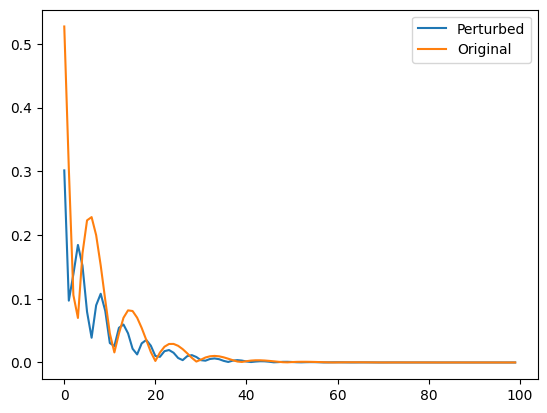

In [9]:

plt.plot(compiler1.metrics['loss_fubini_study'], label="Perturbed")
plt.plot(compiler.metrics['loss_fubini_study'], label="Original")
plt.legend()